In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

from glob import glob
from pathlib import Path
import torch

In [2]:
def load_mask():
    print('loading mask...')
    rle_masks = pd.read_csv('../WC_input/model_50A_slim_ensemble.csv')
    rle_masks = rle_masks[rle_masks['rle_mask'].isnull() == False]
    rle_masks.index = rle_masks['id']
    del rle_masks['id']
    rle_masks = rle_masks.to_dict('index')
    return rle_masks

In [3]:
rle_masks = load_mask()

loading mask...


In [4]:
rle_masks['PM-WWA-20120430-011']

{'rle_mask': '5061 6 5250 14 5441 18 5632 21 5823 25 6015 26 6206 28 6398 30 6589 32 6781 33 6973 34 7164 37 7356 38 7548 39 7739 41 7931 43 8123 44 8315 45 8507 46 8699 47 8890 50 9082 51 9274 52 9466 53 9657 55 9849 56 10041 58 10233 59 10425 60 10616 62 10808 63 11000 64 11192 65 11383 67 11575 68 11767 69 11959 70 12151 71 12343 72 12535 73 12727 74 12919 75 13111 76 13303 77 13495 78 13687 79 13879 81 14070 82 14262 83 14453 85 14645 86 14837 87 15028 89 15220 90 15412 91 15604 92 15796 93 15988 93 16180 94 16372 95 16564 96 16755 98 16947 98 17139 100 17332 100 17524 100 17716 101 17908 102 18101 102 18293 102 18485 103 18677 104 18870 103 19062 103 19254 102 19447 101 19639 100 19831 99 20024 97 20216 96 20408 96 20600 96 20792 96 20984 95 21176 94 21368 94 21560 93 21752 93 21944 93 22136 94 22328 94 22521 92 22713 92 22906 91 23098 91 23291 91 23484 89 23677 88 23870 87 24062 87 24255 86 24447 86 24639 87 24832 86 25024 87 25216 87 25408 86 25600 86 25792 86 25985 85 26177 85 

In [5]:
def do_length_decode(rle, H=192, W=384, fill_value=255):
    mask = np.zeros((H,W), np.uint8)
    if type(rle).__name__ == 'float': return mask
    mask = mask.reshape(-1)
    rle = np.array([int(s) for s in rle.split(' ')]).reshape(-1, 2)
    for r in rle:
        start = r[0]-1
        end = start + r[1]
        mask[start : end] = fill_value
    mask = mask.reshape(W, H).T   # H, W need to swap as transposing.
    return mask

In [6]:
name = 'PM-WWA-20130621-193'
label = '3710'
mask = do_length_decode(rle_masks[name.split('.')[0]]['rle_mask'])

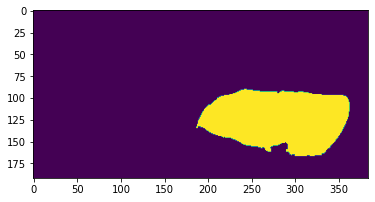

In [7]:
plt.imshow(mask)
plt.show()

In [8]:
mask.shape

(192, 384)

(588, 1662, 3)

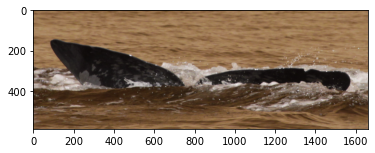

In [9]:
image = cv2.imread(f'../../updated_data/train/{label}/{name}.jpg') 
plt.imshow(image);image.shape

In [10]:
mask = cv2.resize(mask, image.shape[:2][::-1])

In [11]:
mask.shape

(588, 1662)

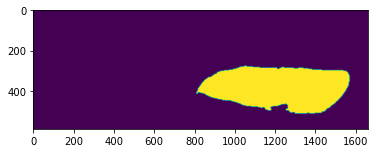

In [12]:
plt.imshow(mask)
plt.show()

In [13]:
def load_bbox():
    # Image,x0,y0,x1,y1
    print('loading bbox...')
    bbox = pd.read_csv('../WC_input/bboxs.csv')
    Images = bbox['Image'].tolist()
    x0s = bbox['x0'].tolist()
    y0s = bbox['y0'].tolist()
    x1s = bbox['x1'].tolist()
    y1s = bbox['y1'].tolist()
    bbox_dict = {}
    for Image,x0,y0,x1,y1 in zip(Images,x0s,y0s,x1s,y1s):
        bbox_dict[Image] = [x0, y0, x1, y1]
    return bbox_dict

In [14]:
bbox_dict = load_bbox()

loading bbox...


In [15]:
x0, y0, x1, y1 = bbox_dict[f'{name}.jpg']

In [16]:
image.shape

(588, 1662, 3)

In [17]:
x0

61

In [18]:
y0

140

In [19]:
x1

1603

In [20]:
y1

410

In [21]:
asasfas

NameError: name 'asasfas' is not defined

In [22]:
image = image[int(y0):int(y1), int(x0):int(x1)]
image.shape

(270, 1542, 3)

In [23]:
mask = mask[int(y0):int(y1), int(x0):int(x1)]
mask.shape

(270, 1542)

(270, 1542, 3)

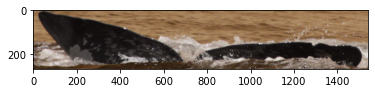

In [24]:
plt.imshow(image); image.shape

(270, 1542)

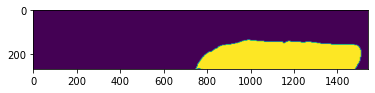

In [25]:
plt.imshow(mask); mask.shape

In [26]:
def transform_valid(image, mask):
    print ('transform_valid', image.shape, mask.shape)

    images = []
    # ipdb.set_trace()
    image = cv2.resize(image, (512, 256))
    mask = cv2.resize(mask, (512, 256))
    mask = mask[:, :, None]
    image = np.concatenate([image, mask], 2)
    raw_image = image.copy()

    image = np.transpose(raw_image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)

    image = np.fliplr(raw_image)
    image = np.transpose(image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)
    return images

In [27]:
img1, img2 = transform_valid(image, mask)

transform_valid (270, 1542, 3) (270, 1542)


In [28]:
img1.shape

torch.Size([4, 256, 512])

In [29]:
img2.shape

torch.Size([4, 256, 512])

In [30]:
img1

tensor([[[0.5843, 0.5765, 0.5843,  ..., 0.6314, 0.6431, 0.6471],
         [0.5882, 0.5882, 0.5922,  ..., 0.6275, 0.6471, 0.6549],
         [0.5765, 0.6000, 0.6039,  ..., 0.6353, 0.6431, 0.6549],
         ...,
         [0.2392, 0.2275, 0.2510,  ..., 0.4471, 0.3490, 0.3451],
         [0.2314, 0.2431, 0.2392,  ..., 0.4000, 0.3490, 0.3529],
         [0.2471, 0.2510, 0.2510,  ..., 0.3882, 0.3451, 0.3529]],

        [[0.4510, 0.4275, 0.4431,  ..., 0.4902, 0.4941, 0.4980],
         [0.4392, 0.4431, 0.4510,  ..., 0.4863, 0.4902, 0.5059],
         [0.4275, 0.4588, 0.4667,  ..., 0.4784, 0.4824, 0.5059],
         ...,
         [0.1569, 0.1451, 0.1490,  ..., 0.3765, 0.2627, 0.2471],
         [0.1490, 0.1490, 0.1451,  ..., 0.3059, 0.2431, 0.2392],
         [0.1529, 0.1569, 0.1569,  ..., 0.2902, 0.2353, 0.2392]],

        [[0.3098, 0.2902, 0.2941,  ..., 0.3333, 0.3608, 0.3647],
         [0.3098, 0.2941, 0.2941,  ..., 0.3373, 0.3529, 0.3686],
         [0.2902, 0.3020, 0.2980,  ..., 0.3294, 0.3451, 0.